In [1]:
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import os.path
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import graph_tool as gt
import sys
sys.path.insert(0, "/Users/mchifala/Desktop/CSCI_5352_Network_Analysis/dnn-community-detection")
import nn2graph
import numpy as np
import pandas as pd
import statsmodels.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape((-1, X_train.shape[1] * X_train.shape[2]))
X_train = (X_train > 0).astype(np.float32)
X_test = X_test.reshape((-1, X_test.shape[1] * X_test.shape[2]))
X_test = (X_test > 0).astype(np.float32)
y_train_orig, y_test_orig = y_train, y_test
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [3]:
hidden_dims = 64
input_dims = X_train.shape[1]
input_0 = Input((input_dims,))
dense_1 = Dense(hidden_dims, activation='relu')(input_0)
dense_2 = Dense(hidden_dims, activation='relu')(dense_1)
dense_3 = Dense(hidden_dims, activation='relu')(dense_2)
dense_4 = Dense(hidden_dims, activation='relu')(dense_3)
dense_out = Dense(10, activation='softmax', kernel_initializer='he_uniform')(dense_4)
model = Model(inputs=input_0, outputs=dense_out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [5]:
load_saved_model = False
if load_saved_model and os.path.exists('data/outputs/mnist_dnn_4x64_10.h5'):
    model = load_model('mnist_dnn_4x64_10.h5')
else:
    model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test))
    model.save('mnist_dnn_4x64_10.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 32us/sample - loss: 0.0421 - acc: 0.9861 - val_loss: 0.1277 - val_acc: 0.9642
Epoch 2/10
60000/60000 [==============================] - 2s 32us/sample - loss: 0.0367 - acc: 0.9874 - val_loss: 0.1137 - val_acc: 0.9684
Epoch 3/10
60000/60000 [==============================] - 2s 33us/sample - loss: 0.0335 - acc: 0.9889 - val_loss: 0.1387 - val_acc: 0.9635
Epoch 4/10
60000/60000 [==============================] - 2s 33us/sample - loss: 0.0310 - acc: 0.9894 - val_loss: 0.1190 - val_acc: 0.9695
Epoch 5/10
60000/60000 [==============================] - 2s 35us/sample - loss: 0.0292 - acc: 0.9903 - val_loss: 0.1551 - val_acc: 0.9608
Epoch 6/10
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0281 - acc: 0.9901 - val_loss: 0.1311 - val_acc: 0.9680
Epoch 7/10
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0241 - acc: 0.9922 - val_loss: 0.

In [6]:
print(model.evaluate(X_test, y_test, verbose=0))
y_pred = model.predict(X_test)

[0.16337209886330528, 0.9664]


#### Convert neural network to graph

In [34]:
#  Get the images of 1's with hats vs. no hats
hats = os.listdir(os.path.join(os.getcwd(),"ones_hats_train"))
hats = np.array([x.split(".")[0] for x in hats], dtype=int)
no_hats = os.listdir(os.path.join(os.getcwd(),"ones_no_hats_train"))
no_hats = np.array([x.split(".")[0] for x in no_hats], dtype=int)

ones_inds = np.concatenate((hats, no_hats))
g_full, g_xs = nn2graph.dense_activations_to_graph(model, X_train[ones_inds])

In [19]:
#N = 5000
#rand_inds = np.concatenate([np.random.choice(np.where(y_test_orig == c)[0], N // 10) for c in range(10)], axis=0)
#g_full, g_xs = nn2graph.dense_activations_to_graph(model, X_test[rand_inds])

In [47]:
layer_sizes = [X_test.shape[-1]] + [layer.units for layer in model.layers if isinstance(layer, Dense)]
i_max = np.argmax([g.num_edges() for g in g_xs])
i_min = np.argmin([g.num_edges() for g in g_xs])
g_max = g_xs[i_max]
g_min = g_xs[i_min]
g_by_class = [[g for j, g in enumerate(g_xs) if y_test_orig[j] == i] for i in range(10)]
print('edge max label: {}'.format(y_test_orig[i_max]))
print('edge min label: {}'.format(y_test_orig[i_min]))
print(layer_sizes)

edge max label: 9
edge min label: 3
[784, 64, 64, 64, 64, 10]


#### Mean weighted degrees vs number of active inputs of 1's

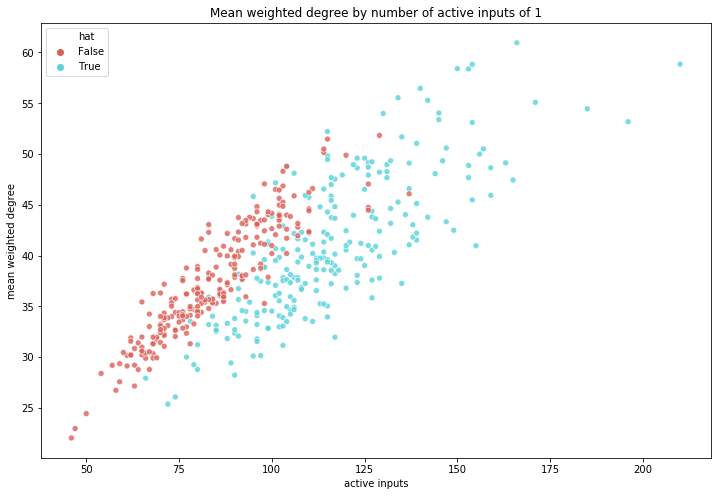

In [46]:
gs_xs_degree_ones = pd.DataFrame({'active inputs': np.sum(X_train[ones_inds], axis=1),
                                  'digit class': y_train_orig[ones_inds],
                                  'mean weighted degree': [float(g.vp['degree'].a.mean()) for g in g_xs]},
                                 index = ones_inds)

gs_xs_degree_ones.reset_index(inplace = True)
gs_xs_degree_ones["hat"] = gs_xs_degree_ones["index"].apply(lambda x: x in hats)
plt.figure(figsize=(12,8))
sns.scatterplot(x='active inputs', y='mean weighted degree', hue='hat',
                palette=sns.color_palette('hls', 2), alpha=0.8,
                data=gs_xs_degree_ones)
plt.title('Mean weighted degree by number of active inputs of 1')
plt.show()

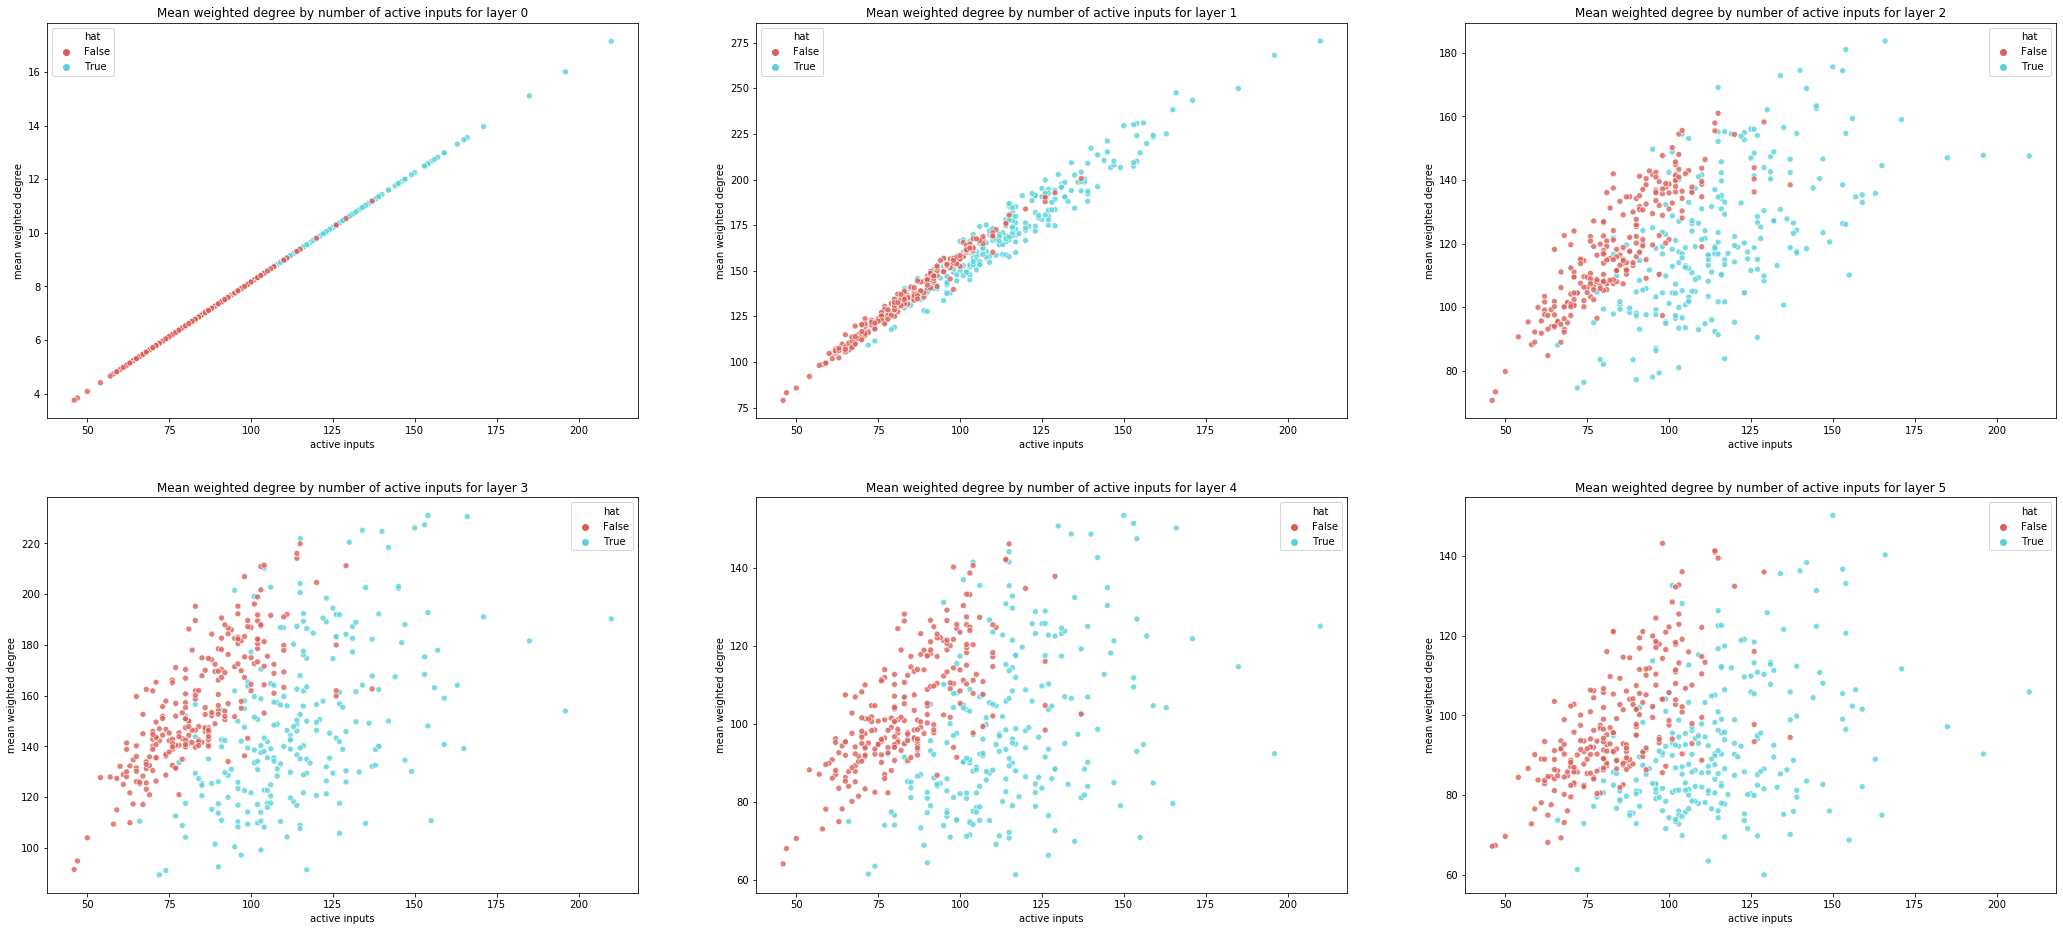

In [54]:
fig, axs = plt.subplots(2, 3, figsize=(3*12,2*8))
for i, (l, st) in enumerate(zip(layer_sizes, np.cumsum(layer_sizes))):
    ax = axs[0 if i < 3 else 1, i%3]
    gs_xs_mean_degree_ones = pd.DataFrame({'active inputs': np.sum(X_train[ones_inds], axis=1),
                                          'digit class': y_train_orig[ones_inds],
                                          'mean weighted degree': [float(g.vp['degree'].a[st-l:st].mean()) for g in g_xs]},
                                          index = ones_inds)

    gs_xs_mean_degree_ones.reset_index(inplace = True)
    gs_xs_mean_degree_ones["hat"] = gs_xs_degree_ones["index"].apply(lambda x: x in hats)
    sns.scatterplot(x='active inputs', y='mean weighted degree', hue='hat',
                    palette=sns.color_palette('hls', 2), alpha=0.8,
                    data=gs_xs_mean_degree_ones,
                    ax=ax)
    ax.set_title('Mean weighted degree by number of active inputs for layer {}'.format(i))
plt.show()